In [5]:
import os
import numpy as np
import pandas as pd
import cv2
import random
# from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, ReLU, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from skimage import feature
from skimage import exposure
# import seaborn as sns
import tensorflow as tf

In [3]:
data_path = "/kaggle/input/dermnet/train"

In [6]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

In [7]:
def preprocess_image(image_path: str, clahe: cv2.CLAHE) -> np.ndarray:
    image = cv2.imread(image_path)
    b, g, r = cv2.split(image)
    
    image = cv2.merge([clahe.apply(b), clahe.apply(g), clahe.apply(r)])
    
    median_filtered_image = cv2.medianBlur(image, 5)
    
    bm, gm, rm = cv2.split(median_filtered_image)

    clahe_image = cv2.merge([clahe.apply(bm), clahe.apply(gm), clahe.apply(rm)])
    
    clahe_image = cv2.cvtColor(clahe_image, cv2.COLOR_BGR2RGB)
    
    return clahe_image

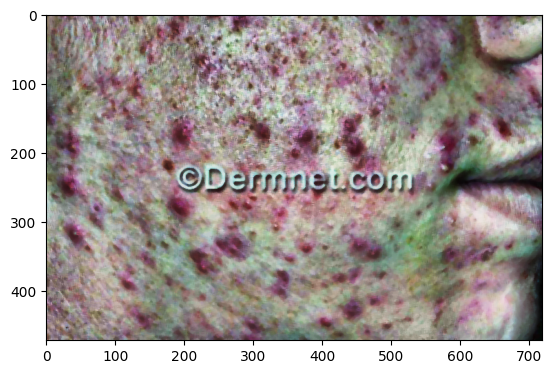

In [9]:
plt.imshow(preprocess_image("2.jpg", clahe))

In [6]:
labels = {}
i = 0

for folder in os.listdir(data_path):
    labels[folder] = i
    i += 1

In [7]:
train_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    files_train = file[:1000]
    
    for file in tqdm(files_train):
        file_path = os.path.join(folder_path, file)
        img = preprocess_image(file_path, clahe)
        img = cv2.resize(img, (224, 224))
        train_data.append((img, labels[folder]))

100%|██████████| 1000/1000 [00:28<00:00, 35.61it/s]


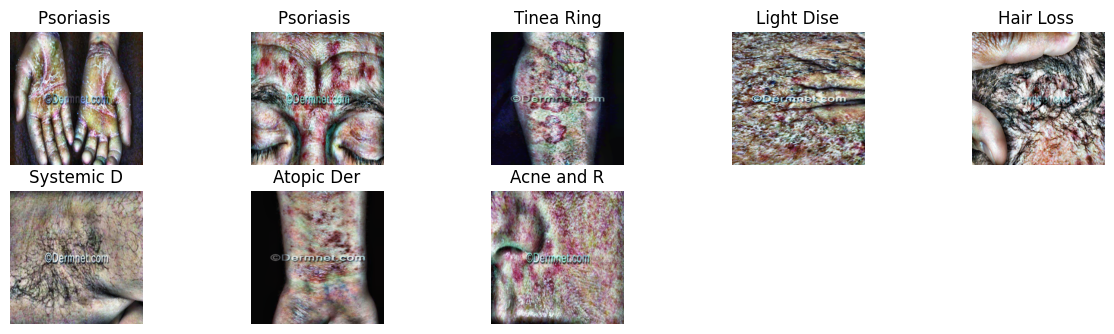

In [10]:
x = random.sample(train_data, 8)
plt.figure(figsize=[15, 10])
for i in range(8):
    img, label = x[i]
    plt.subplot(5, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(list(labels.keys())[label][:10])
    plt.axis('off')

In [11]:
random.shuffle(train_data)

In [12]:
num_classes = 23

In [13]:
X_train, y_train = zip(*train_data)

X_train = np.array(X_train)

x_val = np.array(y_train)

y_train_one_hot = to_categorical(y_train, num_classes)

In [14]:
X_train.shape

(13971, 224, 224, 3)

In [15]:
def build_Model() -> Model:
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [16]:
model = build_Model()
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'categorical_accuracy',
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Recall(),
    ]
)

checkpoint = ModelCheckpoint("skin_weights.h5", monitor='loss', verbose=1, save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=2, verbose=1, mode='auto', min_delta=0.0001, cooldown=5)

early_stop = EarlyStopping(monitor='loss', mode='min', patience=10, restore_best_weights=True)

In [18]:
history = model.fit(X_train, y_train_one_hot,
                   epochs = 100, batch_size=32,
                   shuffle=True,
                   callbacks=[checkpoint, reduceLROnPlat, early_stop]
                   )

Epoch 1/100
437/437 [==============================] - ETA: 0s - loss: 2.5698 - categorical_accuracy: 0.2628 - precision: 0.6746 - auc: 0.7848 - recall: 0.0686
Epoch 1: loss improved from inf to 2.56976, saving model to skin_weights.h5
437/437 [==============================] - 36s 58ms/step - loss: 2.5698 - categorical_accuracy: 0.2628 - precision: 0.6746 - auc: 0.7848 - recall: 0.0686 - lr: 0.0010
Epoch 2/100
436/437 [============================>.] - ETA: 0s - loss: 2.1890 - categorical_accuracy: 0.3460 - precision: 0.7241 - auc: 0.8566 - recall: 0.1326
Epoch 2: loss improved from 2.56976 to 2.18921, saving model to skin_weights.h5
437/437 [==============================] - 25s 57ms/step - loss: 2.1892 - categorical_accuracy: 0.3459 - precision: 0.7245 - auc: 0.8565 - recall: 0.1327 - lr: 0.0010
Epoch 3/100
436/437 [============================>.] - ETA: 0s - loss: 1.9912 - categorical_accuracy: 0.3976 - precision: 0.7187 - auc: 0.8865 - recall: 0.1813
Epoch 3: loss improved from 2.

In [19]:
loss, accuracy, _, _, _ = model.evaluate(X_train, y_train_one_hot)
print("Accuracy: ", accuracy)
print("Loss: ", loss)

437/437 [==============================] - 25s 55ms/step - loss: 0.0304 - categorical_accuracy: 0.9800 - precision: 0.9800 - auc: 1.0000 - recall: 0.9799
Accuracy:  0.9799584746360779
Loss:  0.030406657606363297


In [21]:
model.save('skin_detection.h5')

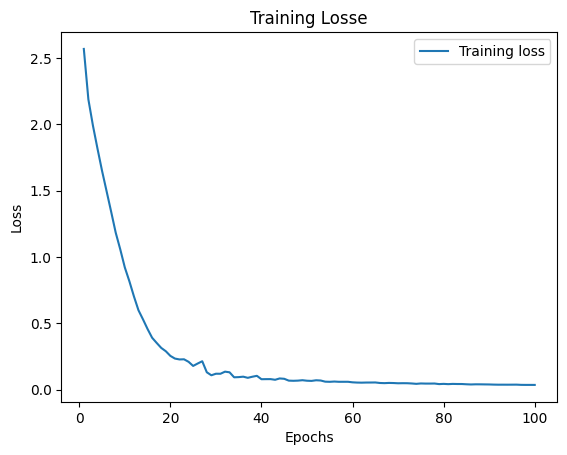

In [24]:
train_loss = history.history['loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss,label='Training loss')
plt.title('Training Losse')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

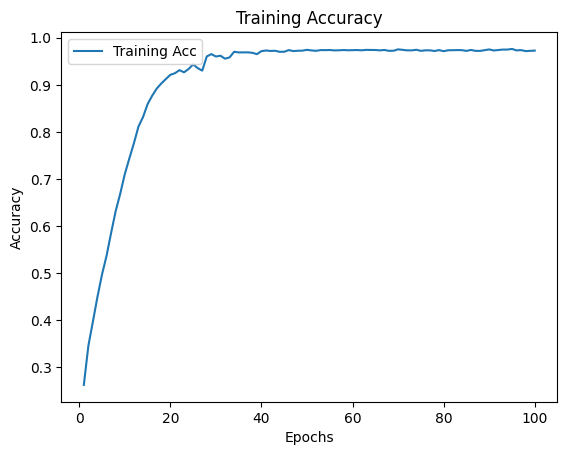

In [25]:
train_acc = history.history['categorical_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc,label='Training Acc')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [30]:
predicted_class = model.predict(X_train)

437/437 [==============================] - 22s 50ms/step


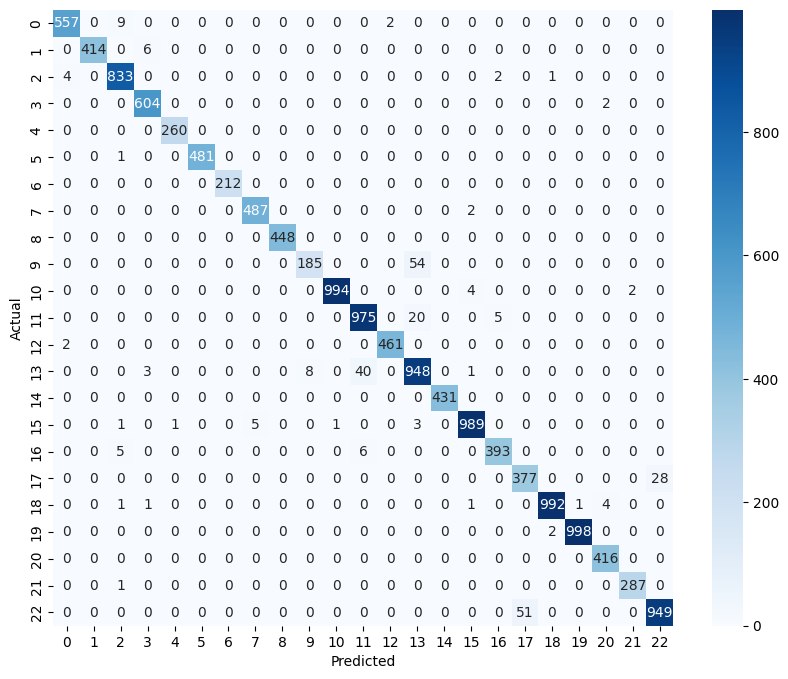

In [31]:
y_pred = np.argmax(predicted_class, axis=1)
y_true = np.argmax(y_train_one_hot, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()